In [1]:
import os
import functools
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import pil_to_tensor
from huggingface_hub import hf_hub_download
from PIL import Image, ImageShow
import PIL
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.utils import make_image_grid
from IPython.core.debugger import Pdb
import cv2
import numpy as np
from src.models.attention_processor import SkipAttnProcessor
from src.pipelines.spacat_pipeline import TryOnPipeline
from src.dataset.vitonhd import VITONHDDataset
from src.utils import get_project_root, show, init_attn_processor

In [2]:
def merge(
    img1: PIL.Image.Image,
    img2: PIL.Image.Image
) -> PIL.Image.Image:
    assert img1.size[1] == img2.size[1]
    h, w = img1.size[1], img1.size[0]
    w2 = img2.size[0]
    img = Image.new('RGB', (w + w2, h))
    img.paste(img1, (0, 0))
    img.paste(img2, (w, 0))
    return img

In [3]:
def apply_poisson_blending(
    original_img: PIL.Image.Image,
    tryon_img: PIL.Image.Image,
    mask_img: PIL.Image.Image
) -> PIL.Image.Image:
    w, h = original_img.size
    original_img = np.array(original_img)
    tryon_img = np.array(tryon_img)
    mask_img = np.array(mask_img)
    mask_img = 255 - mask_img
    output = cv2.seamlessClone(original_img, tryon_img, mask_img, (w//2, h//2), cv2.NORMAL_CLONE)
    return Image.fromarray(output, mode='RGB')

In [4]:
""" Download models from Huggingface Hub
"""
PROJECT_ROOT_PATH = get_project_root()
repo_id = 'bui/Navier-1'
base_folder = 'ckpt-170000'

# unet
unet_path = hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'unet'),
    filename='diffusion_pytorch_model.safetensors',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'unet'),
    filename='config.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)

# vae
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'vae'),
    filename='diffusion_pytorch_model.safetensors',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'vae'),
    filename='config.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
# scheduler
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'scheduler'),
    filename='scheduler_config.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
# model_index.json
hf_hub_download(
    repo_id=repo_id,
    subfolder=base_folder,
    filename='model_index.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)

model_root_path = os.path.dirname(os.path.dirname(unet_path))
model_root_path

'/home/jupyter/H-engine/checkpoints/navier-1/ckpt-170000'

In [5]:
vae = AutoencoderKL.from_pretrained(
    model_root_path,
    subfolder='vae',
    torch_dtype=torch.float16
)
scheduler = DDPMScheduler.from_pretrained(
    model_root_path,
    subfolder='scheduler'
)

unet = UNet2DConditionModel.from_pretrained(
    model_root_path,
    subfolder='unet',
    torch_dtype=torch.float16
)
init_attn_processor(unet, cross_attn_cls=SkipAttnProcessor)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
test_dataset = VITONHDDataset(
    data_rootpath=os.path.join(PROJECT_ROOT_PATH, 'datasets', 'vitonhd'),
    use_trainset=False,
    height=512,
    width=384,
    use_CLIPVision=True
)

bs = 5
f = 40 # for comparison
generator = torch.manual_seed(1996 + bs*f)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    generator=generator,
)

In [7]:
pipe = TryOnPipeline(
    unet=unet,
    vae=vae,
    scheduler=scheduler
).to(device)

In [8]:
""" Generate try-on image and concat with its original one (for qualitative comparison)
then build the image grid of all of generated pairs and save it to disk.
"""
h, w = 512, 384
use_poisson_blending = True
display_mask = True
tryon_list = []
outfit_list = []
with torch.inference_mode():
    with torch.amp.autocast(device):
        for idx, batch in enumerate(test_dataloader):
            next_batch = next(iter(test_dataloader))
            for i in range(bs):
                image_x = batch['image'][i].squeeze(0).repeat(bs, 1, 1, 1)
                mask_x = batch['mask'][i].squeeze(0).repeat(bs, 1, 1, 1)
                densepose_x = batch['densepose'][i].squeeze(0).repeat(bs, 1, 1, 1)
                images = pipe(
                    image=image_x.to(device),
                    mask_image=mask_x.to(device),
                    densepose_image=densepose_x.to(device),
                    cloth_image=next_batch['cloth_raw'].to(device),
                    height=h,
                    width=w,
                    generator=generator,
                ).images
                original_img = Image.open(batch['original_image_path'][i]).resize((w, h))
                if use_poisson_blending:
                    original_images = [Image.open(batch['original_image_path'][i]).resize((w, h))] * bs
                    mask_images = [Image.open(batch['original_mask_path'][i]).resize((w, h))] * bs
                    images = [apply_poisson_blending(o_img, t_img, m_img) for o_img, t_img, m_img in zip(original_images, images, mask_images)] # apply poisson blending
                tryon_list.append(functools.reduce(merge, [original_img] + images))
            outfit_list = [Image.open(im_path).resize((w, h)) for im_path in next_batch['original_cloth_path']]
            empty_img = Image.new('RGB', (w, h), (255, 255, 255)) # white image
            outfit_list.insert(0, empty_img)
            break
del pipe
torch.cuda.empty_cache()

/home/jupyter/H-engine/.venv/lib/python3.9/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `vae_latent_channels` directly via 'VaeImageProcessor' object attribute is deprecated. Please access 'vae_latent_channels' over 'VaeImageProcessor's config object instead, e.g. 'scheduler.config.vae_latent_channels'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/jupyter/H-engine/.venv/lib/python3.9/site-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/jupyter/H-engine/.venv/lib/python3.9/site-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.992156982421875]
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/jupyter/H-engine/.venv/lib/python3.9/site-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.9450981616973877]
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

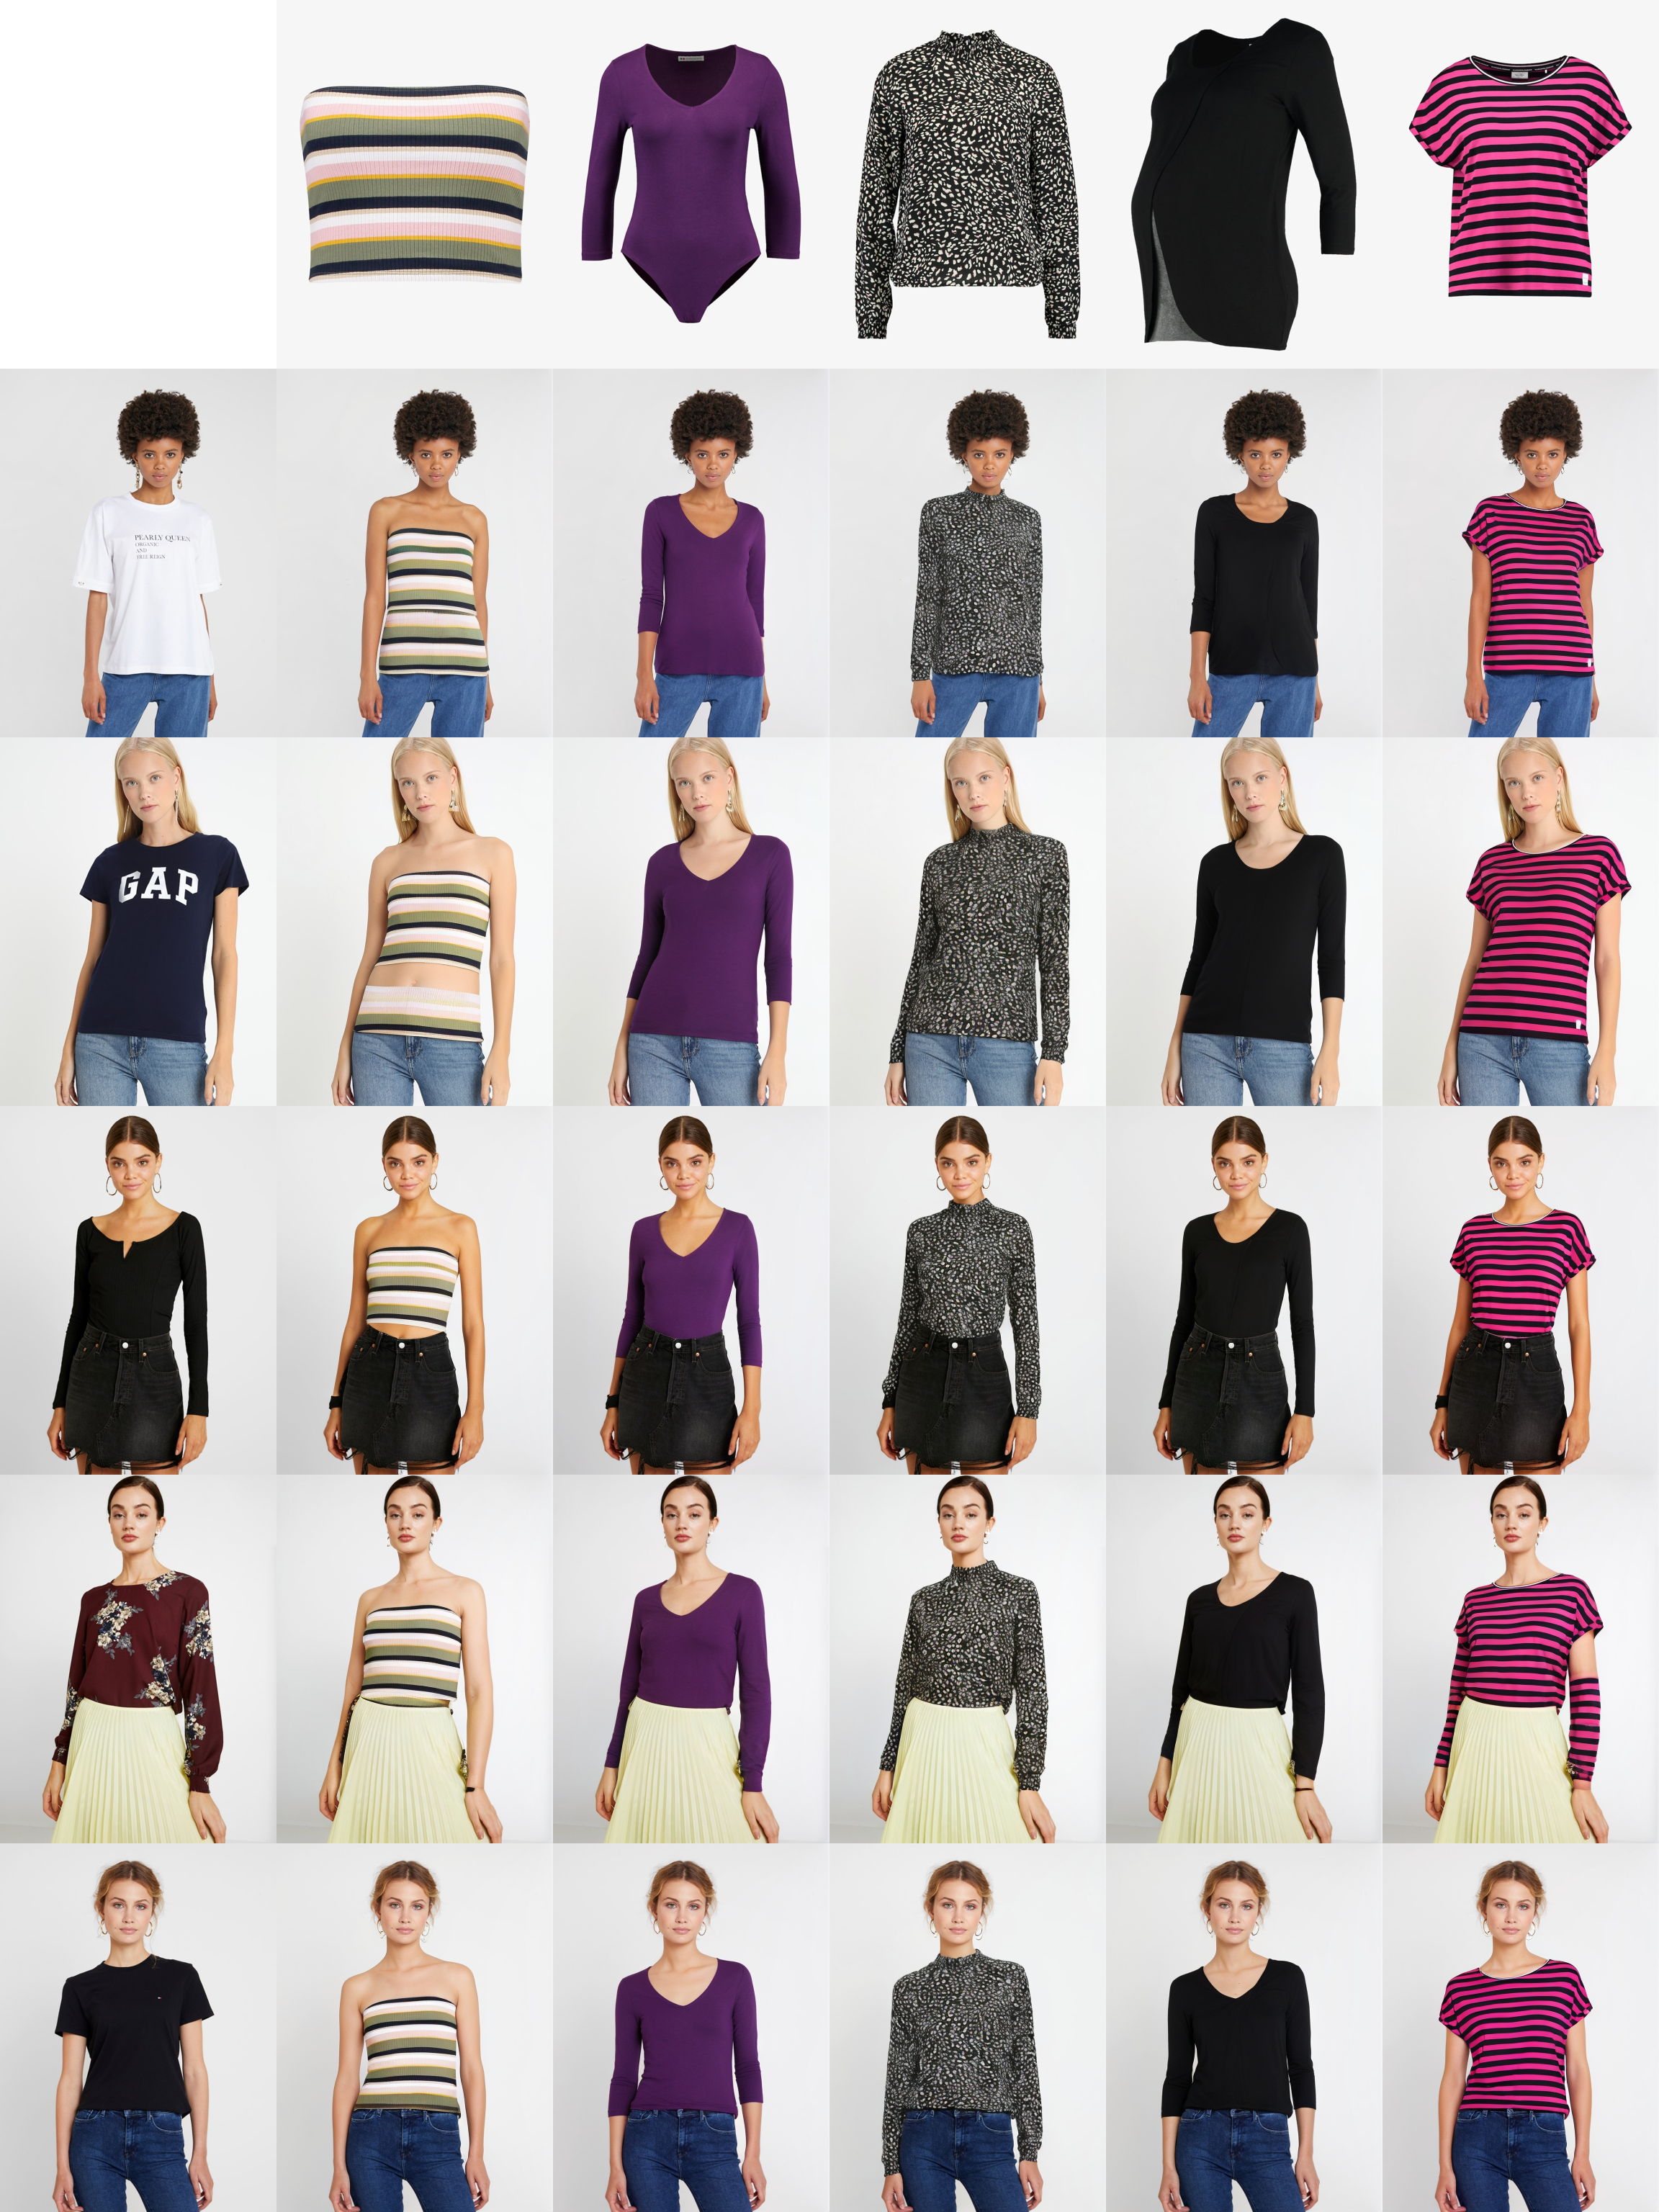

In [9]:
first_row = functools.reduce(merge, outfit_list)
output = make_image_grid(
    images=[first_row] + tryon_list,
    rows=bs + 1,
    cols=1
)
output

In [10]:
save_path = os.path.join(PROJECT_ROOT_PATH, 'results', 'navier-1', 'beta', base_folder, 'one_person_many_outfits')
os.makedirs(save_path, exist_ok=True)
fname = f'bs{bs}-f{f}-poisson.png' if use_poisson_blending else f'bs{bs}-f{f}.png'
output.save(Path(save_path, fname))